# 0 環境構築

In [1]:
!git clone https://github.com/EliSchwartz/imagenet-sample-images.git

fatal: destination path 'imagenet-sample-images' already exists and is not an empty directory.


In [2]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torchvision import models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchinfo

# 1 画像のpathとlabelの抽出

In [4]:
image_path_list = sorted(glob.glob("/content/imagenet-sample-images/*.JPEG"))
image_path_list[:10]

['/content/imagenet-sample-images/n01440764_tench.JPEG',
 '/content/imagenet-sample-images/n01443537_goldfish.JPEG',
 '/content/imagenet-sample-images/n01484850_great_white_shark.JPEG',
 '/content/imagenet-sample-images/n01491361_tiger_shark.JPEG',
 '/content/imagenet-sample-images/n01494475_hammerhead.JPEG',
 '/content/imagenet-sample-images/n01496331_electric_ray.JPEG',
 '/content/imagenet-sample-images/n01498041_stingray.JPEG',
 '/content/imagenet-sample-images/n01514668_cock.JPEG',
 '/content/imagenet-sample-images/n01514859_hen.JPEG',
 '/content/imagenet-sample-images/n01518878_ostrich.JPEG']

In [5]:
def label_name_extract(image_path, target):
  image_path_basename = os.path.basename(image_path)
  image_path_no_extension = os.path.splitext(image_path_basename)[0]
  idx = image_path_no_extension.find(target)
  label_name = image_path_no_extension[idx+1:]
  return label_name

In [6]:
target = '_'
label_name_list = [label_name_extract(image_path, target) for image_path in image_path_list]
label_name_list[:10]

['tench',
 'goldfish',
 'great_white_shark',
 'tiger_shark',
 'hammerhead',
 'electric_ray',
 'stingray',
 'cock',
 'hen',
 'ostrich']

# 2 ImageNetのデータセット

In [7]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor(),
 transforms.Normalize(
 mean=IMAGENET_MEAN,
 std=IMAGENET_STD
 )])


In [8]:
class ImageNetDataset(Dataset):
    def __init__(self, image_path_list, label_name_list, transform=None):

      self.image_path_list = image_path_list
      self.label_name_list = label_name_list
      self.transform = transform

    def __len__(self):

      return len(self.label_name_list)

    def __getitem__(self, idx):

      image_open = Image.open(image_path_list[idx]).convert("RGB")
      label_name = self.label_name_list[idx]
      if self.transform:
          image = self.transform(image_open)

      return image, label_name

In [9]:
dataset = ImageNetDataset(image_path_list, label_name_list, transform=transform)

In [10]:
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [11]:
image_tensor, labels = next(iter(dataloader))

In [12]:
image_tensor.shape

torch.Size([10, 3, 224, 224])

In [13]:
labels

('giant_panda',
 'hog',
 'capuchin',
 'miniskirt',
 'frying_pan',
 'desktop_computer',
 'abacus',
 'otter',
 'gong',
 'carbonara')

# 3 SENet

参考 : https://github.com/hujie-frank/SENet <br>
参考 : https://github.com/moskomule/senet.pytorch

In [14]:
!git clone https://github.com/moskomule/senet.pytorch.git senet_repo
%cd /content/senet_repo

fatal: destination path 'senet_repo' already exists and is not an empty directory.
/content/senet_repo


In [15]:
from senet.se_resnet import se_resnet152

In [16]:
model = se_resnet152()

In [17]:
image_tensor.shape

torch.Size([10, 3, 224, 224])

In [18]:
torchinfo.summary(model, image_tensor.shape, depth=1)

Layer (type:depth-idx)                        Output Shape              Param #
ResNet                                        [10, 1000]                --
├─Conv2d: 1-1                                 [10, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                            [10, 64, 112, 112]        128
├─ReLU: 1-3                                   [10, 64, 112, 112]        --
├─MaxPool2d: 1-4                              [10, 64, 56, 56]          --
├─Sequential: 1-5                             [10, 256, 56, 56]         240,384
├─Sequential: 1-6                             [10, 512, 28, 28]         2,601,984
├─Sequential: 1-7                             [10, 1024, 14, 14]        45,332,480
├─Sequential: 1-8                             [10, 2048, 7, 7]          16,537,600
├─AdaptiveAvgPool2d: 1-9                      [10, 2048, 1, 1]          --
├─Linear: 1-10                                [10, 1000]                2,049,000
Total params: 66,770,984
Trainable params: 66,770,984
No

In [19]:
torchinfo.summary(model, image_tensor.shape, depth=2)

Layer (type:depth-idx)                        Output Shape              Param #
ResNet                                        [10, 1000]                --
├─Conv2d: 1-1                                 [10, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                            [10, 64, 112, 112]        128
├─ReLU: 1-3                                   [10, 64, 112, 112]        --
├─MaxPool2d: 1-4                              [10, 64, 56, 56]          --
├─Sequential: 1-5                             [10, 256, 56, 56]         --
│    └─SEBottleneck: 2-1                      [10, 256, 56, 56]         83,200
│    └─SEBottleneck: 2-2                      [10, 256, 56, 56]         78,592
│    └─SEBottleneck: 2-3                      [10, 256, 56, 56]         78,592
├─Sequential: 1-6                             [10, 512, 28, 28]         --
│    └─SEBottleneck: 2-4                      [10, 512, 28, 28]         412,160
│    └─SEBottleneck: 2-5                      [10, 512, 28, 28]         31

In [20]:
torchinfo.summary(model, image_tensor.shape, depth=3)

Layer (type:depth-idx)                        Output Shape              Param #
ResNet                                        [10, 1000]                --
├─Conv2d: 1-1                                 [10, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                            [10, 64, 112, 112]        128
├─ReLU: 1-3                                   [10, 64, 112, 112]        --
├─MaxPool2d: 1-4                              [10, 64, 56, 56]          --
├─Sequential: 1-5                             [10, 256, 56, 56]         --
│    └─SEBottleneck: 2-1                      [10, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                       [10, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2                  [10, 64, 56, 56]          128
│    │    └─ReLU: 3-3                         [10, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                       [10, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5                  [10, 64, 56, 56]          128
│    │ 

In [21]:
torchinfo.summary(model, image_tensor.shape, depth=5)

Layer (type:depth-idx)                        Output Shape              Param #
ResNet                                        [10, 1000]                --
├─Conv2d: 1-1                                 [10, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                            [10, 64, 112, 112]        128
├─ReLU: 1-3                                   [10, 64, 112, 112]        --
├─MaxPool2d: 1-4                              [10, 64, 56, 56]          --
├─Sequential: 1-5                             [10, 256, 56, 56]         --
│    └─SEBottleneck: 2-1                      [10, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                       [10, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2                  [10, 64, 56, 56]          128
│    │    └─ReLU: 3-3                         [10, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                       [10, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5                  [10, 64, 56, 56]          128
│    │ 

In [22]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): SEBottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Se

# 4 モデルの出力

In [23]:
model.eval()

output = model(image_tensor)
print(output.shape)
print(output.argmax(axis=1))

predict = [label_name_list[label] for label in output.argmax(axis=1)]
print(labels)
print(predict)

torch.Size([10, 1000])
tensor([648, 714, 390, 390, 390, 390, 315, 596, 390,  84])
('giant_panda', 'hog', 'capuchin', 'miniskirt', 'frying_pan', 'desktop_computer', 'abacus', 'otter', 'gong', 'carbonara')
['medicine_chest', 'pick', 'eel', 'eel', 'eel', 'eel', 'mantis', 'hatchet', 'eel', 'peacock']


# 5 画像と予測の確認

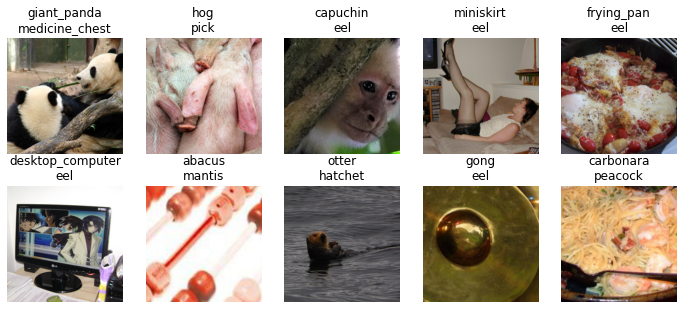

In [24]:
image_n = 10
row = 2
col = 5

plt.figure(figsize=(12, 5))

for i in range(image_n):
  
  x = image_tensor[i].to('cpu').mul(torch.FloatTensor(IMAGENET_STD).view(3, 1, 1))
  x = x.add(torch.FloatTensor(IMAGENET_MEAN).view(3, 1, 1)).detach().numpy()
  plt.subplot(row, col, i+1)
  plt.imshow(x.transpose(1, 2, 0))
  plt.axis('off')
  plt.title(labels[i]+"\n"+predict[i])